# Test Uncertainty Propagation (UP) techniques on Linear Freeflyer 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import time

import sys, os
sys.path.append('../..')
from models.LTI_nD import Model
import utils

from scipy.spatial import ConvexHull

### Load Model + True Dynamics + Problem + Nominal Trajectory

In [2]:
model = Model()
model.reset()

[LTI_nD::__init__] Initializing model.
[LTI_nD::reset] resetting dynamics.
[LTI_nD::reset] resetting dynamics.


## Propagate Uncertainty

In [3]:
N_MC = 256

In [4]:
# Uniform sampling (randUP)
Xs_uniform = model.simulate_batch(N_MC = N_MC)

# Adversarial sampling (robUP!)
new_x0s_MC, new_controls_MC     = model.adv_sample_params(Xs_uniform)
model.x0s_MC, model.controls_MC = new_x0s_MC, new_controls_MC
Xs_adv                          = model.simulate_batch(N_MC = N_MC, B_resample=False)

### RSS METHOD

In [5]:
N_per_dim = 4

In [6]:
# N_per_dim**4

In [7]:
# compute edges of RSS method
x0s                            = model.create_deltapacking_x0s(N_per_dim)

controls                       = np.linspace(model.u_min, model.u_max, num=2, endpoint=True)
us_00, us_11, us_22, us_33     = np.meshgrid(controls[:,0],controls[:,1],controls[:,2],controls[:,3])
controls                       = np.array([us_00.ravel(), us_11.ravel(), us_22.ravel(), us_33.ravel()]).T

Xs_edges_RSS_x0s = (model.A @ x0s.T).T
Xs_edges_RSS_us  = (model.B @ controls.T).T
Xs_edges_RSS     = np.zeros((Xs_edges_RSS_x0s.shape[0],Xs_edges_RSS_us.shape[0],model.n_x))
# minkowski sum
for i in range(Xs_edges_RSS_x0s.shape[0]):
    for j in range(Xs_edges_RSS_us.shape[0]):
        Xs_edges_RSS[i,j,:] = Xs_edges_RSS_x0s[i,:] + Xs_edges_RSS_us[j,:]

In [8]:
vol_RSS = model.compute_volume_RSS_method(N_per_dim)

4  per dim: overlap!


## Compare visually

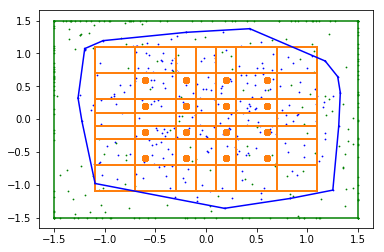

In [9]:
from utils.viz import plot_pts_2d, plot_trajs_2d
idx = [2,3]

plot_pts_2d(Xs_uniform, idx=idx, markerwidth=0.6, color='b')
plot_pts_2d(Xs_adv, idx=idx, markerwidth=0.6, color='g')
# plot_pts_2d(Xs_RSS, idx=idx, color='C1')

plot_pts_2d(Xs_edges_RSS_x0s, idx=idx, color='C1')
for i in range(Xs_edges_RSS.shape[0]):
    hull = ConvexHull(Xs_edges_RSS[i,:,idx].T)
    for simplex in hull.simplices:
        plt.plot(Xs_edges_RSS[i,simplex, idx[0]], Xs_edges_RSS[i,simplex, idx[1]], color='C1')

hull_unif = ConvexHull(Xs_uniform[:,idx])
for simplex in hull_unif.simplices:
    plt.plot(Xs_uniform[simplex, idx[0]], Xs_uniform[simplex, idx[1]], 'b-')
hull_adv = ConvexHull(Xs_adv[:,idx])
for simplex in hull_adv.simplices:
    plt.plot(Xs_adv[simplex, idx[0]], Xs_adv[simplex, idx[1]], 'g-')

In [10]:
# 2d (debug)
print('Vol unif=',hull_unif.volume)
print('Vol adv =',hull_adv.volume)
print('Vol RSS =',np.sqrt(vol_RSS))

Vol unif= 5.986150903072834
Vol adv = 9.0
Vol RSS = 4.840000000000001


In [11]:
# nD
print('Vol RSS =',model.compute_volume_RSS_method(N_per_dim))
print('Vol unif=',ConvexHull(Xs_uniform).volume)
print('Vol adv =',ConvexHull(Xs_adv).volume)

4  per dim: overlap!
Vol RSS = 23.42560000000001
Vol unif= 22.11470422712535
Vol adv = 78.3790913750501


## run it for multiple numbers of samples

In [12]:
8**4

4096

In [13]:
if model.n_x == 3:
    PER_DIM_MAX = 16
elif model.n_x == 4:
    PER_DIM_MAX = 8
else:
    raise NotImplementedError("Untested dimension.")
vec_N_MC            = np.linspace(10, PER_DIM_MAX**model.n_x, num=500, endpoint=True)
# vec_N_MC            = np.linspace(10, PER_DIM_MAX**model.n_x, num=4, endpoint=True)
vec_samples_per_dim = np.linspace(2, PER_DIM_MAX, num=PER_DIM_MAX-2, endpoint=True)

In [14]:
B                = 10 # batch size
mat_volumes_unif = np.zeros((len(vec_N_MC), B))
mat_volumes_adv  = np.zeros((len(vec_N_MC), B))
vec_volumes_RSS  = np.zeros(len(vec_samples_per_dim))

In [15]:
# Run (randUP) and (robUP!) over batches
for idx, N_MC in enumerate(vec_N_MC):
    N_MC = int(N_MC)
    for jdx in range(B):
        Xs_uniform = model.simulate_batch(N_MC = N_MC)

        new_x0s_MC, new_controls_MC     = model.adv_sample_params(Xs_uniform)
        model.x0s_MC, model.controls_MC = new_x0s_MC, new_controls_MC

        Xs_adv                          = model.simulate_batch(N_MC = N_MC, B_resample=False)

        mat_volumes_unif[idx,jdx] = ConvexHull(Xs_uniform).volume
        mat_volumes_adv[idx,jdx]  = ConvexHull(Xs_adv).volume

In [16]:
idx

499

In [17]:
# Compute RSS volume
for idx, N_per_dim in enumerate(vec_samples_per_dim):
    vec_volumes_RSS[idx] = model.compute_volume_RSS_method(N_per_dim)

2  per dim: overlap!
3  per dim: overlap!
4  per dim: overlap!
5  per dim: overlap!
6  per dim: overlap!
8  per dim: overlap!


In [18]:
# Compute True Volume
vol_true = np.prod(model.x0_max+model.u_max-model.x0_min-model.u_min)
vol_true

81.0

In [19]:
mat_volumes_unif_orig = mat_volumes_unif.copy()
mat_volumes_adv_orig  = mat_volumes_adv.copy()
vec_volumes_RSS_orig  = vec_volumes_RSS.copy()
vol_true_orig         = vol_true

## plot results

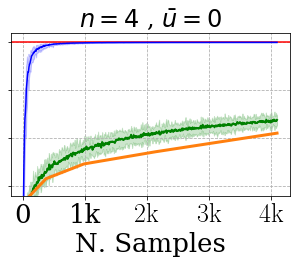

In [20]:
# Normalize in [%]
mat_volumes_unif = mat_volumes_unif_orig/(vol_true_orig/100.)
mat_volumes_adv = mat_volumes_adv_orig/(vol_true_orig/100.)
vec_volumes_RSS = vec_volumes_RSS_orig/(vol_true_orig/100.)
vol_true = 100.

from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(5, 3))

truth_str = r'True, $\bar{u}=' + str(model.u_mag) + '$'
plt.axhline(y=vol_true, color='r', label=truth_str)

title_str = r'$n=' + str(model.n_x) + '$' + r' , $\bar{u}=' + str(int(model.u_mag)) + '$'
plt.title(title_str, fontsize=24)

# 3sigmas corresponds to approx. 99.7% confidence interval
mean_vols_unif, vars_vols_unif = np.mean(mat_volumes_unif, 1), np.sqrt( np.var(mat_volumes_unif, axis=1) )
plt.plot(vec_N_MC, mean_vols_unif,         'g', label='randUP', linewidth=2)
plt.fill_between(vec_N_MC, mean_vols_unif-3.*vars_vols_unif, mean_vols_unif+3.*vars_vols_unif, 
                                     color='g', alpha=0.2)

mean_vols_adv, vars_vols_adv = np.mean(mat_volumes_adv, 1), np.sqrt( np.var(mat_volumes_adv, axis=1) )
plt.plot(vec_N_MC, mean_vols_adv,         'b', label='robUP!')
plt.fill_between(vec_N_MC, mean_vols_adv-3.*vars_vols_adv, mean_vols_adv+3.*vars_vols_adv, 
                                     color='b', alpha=0.2)

plt.plot(vec_samples_per_dim**model.n_x, vec_volumes_RSS, 'C1', label='Grid+Union', linewidth=3)


rc('text', usetex=True)
# plt.legend(fontsize=16, loc='lower right')

ax.tick_params("both", labelsize=26) 
# ax.tick_params("y",       labelsize=26) 
plt.xticks([0,1000,2000,3000,4000], ('0', '1k', '2k', '3k', '4k'))
plt.yticks([25,50,75,100])

plt.ylim([20,105])

ax.set_xlabel('N. Samples',                                    fontsize=26)

if model.u_mag==0.5 and model.n_x==3:
    ax.set_ylabel(r'Vol($\mathcal{X}_1$) [\%]', rotation="vertical",fontsize=30, labelpad=24)
else:
    ax.yaxis.set_major_formatter(NullFormatter())

plt.grid(True, which='both', linestyle='--')

In [21]:
vec_N_MC[-1]

4096.0